<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#About-dataset" data-toc-modified-id="About-dataset-0.1">About dataset</a></span></li><li><span><a href="#Downloading-Data" data-toc-modified-id="Downloading-Data-0.2">Downloading Data</a></span></li></ul></li><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-1">Pre-processing</a></span></li><li><span><a href="#Setting-up-the-Decision-Tree" data-toc-modified-id="Setting-up-the-Decision-Tree-2">Setting up the Decision Tree</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-3">Modeling</a></span></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-4">Prediction</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-5">Evaluation</a></span></li><li><span><a href="#Practice" data-toc-modified-id="Practice-6">Practice</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-7">Visualization</a></span></li></ul></div>

In [1]:
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
# from sklearn.externals.six import StringIO
# import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

In [4]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, X_pred))

NameError: name 'y_test' is not defined

# Decision Trees

In this lab exercise, you will learn a popular machine learning algorithm, Decision Tree. You will use this classification algorithm to build a model from historical data of patients, and their respond to different medications. Then you use the trained decision tree to predict the class of a unknown patient, or to find a proper drug for a new patient.

### About dataset
Imagine that you are a medical researcher compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient responded to one of 5 medications, Drug A, Drug B, Drug c, Drug x and y. 

Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The **feature sets** of this dataset are **Age**, **Sex**, **Blood Pressure**, and **Cholesterol of patients**, and the **target** is **the drug** that each patient responded to. 

It is an example of binary classifier, and you can use the training part of the dataset 
to build a decision tree, and then use it to predict the class of a unknown patient, or to prescribe it to a new patient.


### Downloading Data
To download the data, we will use `!wget` to download it from IBM Object Storage.

In [61]:
# !wget -O drug200.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/drug200.csv

In [9]:
PATH = "./data/"

In [10]:
!ls {PATH}

cell_samples.csv            moviedataset
drug200.csv                 teleCust1000t.csv
hierarchical_clustering.csv


now, read data using pandas dataframe:

In [11]:
df = pd.read_csv(PATH+"drug200.csv", delimiter=",")
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [12]:
pd.DataFrame(df.dtypes).T

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,int64,object,object,object,float64,object


## Pre-processing

Using <b>my_data</b> as the Drug.csv data read by pandas, declare the following variables: <br>
<ul>
    <li> <b> X </b> as the <b> Feature Matrix </b> (data of my_data) </li>    
    <li> <b> y </b> as the <b> response vector (target) </b> </li>   
</ul>

Remove the column containing the target name since it doesn't contain numeric values.

In [13]:
X = df[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values
X[0:5]

array([[23, 'F', 'HIGH', 'HIGH', 25.355],
       [47, 'M', 'LOW', 'HIGH', 13.093],
       [47, 'M', 'LOW', 'HIGH', 10.114],
       [28, 'F', 'NORMAL', 'HIGH', 7.798],
       [61, 'F', 'LOW', 'HIGH', 18.043]], dtype=object)

As you may figure out, some featurs in this dataset are catergorical such as __Sex__ or __BP__. Unfortunately, Sklearn Decision Trees do not handle categorical variables. But still we can convert these features to numerical values. __pandas.get_dummies()__
Convert categorical variable into dummy/indicator variables.

In [14]:
from sklearn import preprocessing

le_sex = preprocessing.LabelEncoder()
le_sex.fit(['F','M'])
X[:, 1] = le_sex.transform(X[:, 1]) 


le_BP = preprocessing.LabelEncoder()
le_BP.fit(['LOW', 'NORMAL', 'HIGH'])
X[:,2] = le_BP.transform(X[:, 2])


le_Chol = preprocessing.LabelEncoder()
le_Chol.fit([ 'NORMAL', 'HIGH'])
X[:, 3] = le_Chol.transform(X[:,3]) 

X[0:5]

array([[23, 0, 0, 0, 25.355],
       [47, 1, 1, 0, 13.093],
       [47, 1, 1, 0, 10.114],
       [28, 0, 2, 0, 7.798],
       [61, 0, 1, 0, 18.043]], dtype=object)

In [15]:
pd.DataFrame(X, columns=['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K'])

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,0,0,0,25.355
1,47,1,1,0,13.093
2,47,1,1,0,10.114
3,28,0,2,0,7.798
4,61,0,1,0,18.043
...,...,...,...,...,...
195,56,0,1,0,11.567
196,16,1,1,0,12.006
197,52,1,2,0,9.894
198,23,1,2,1,14.02


Now we can fill the target variable.

In [16]:
y = df["Drug"]
y[0:5]

0    drugY
1    drugC
2    drugC
3    drugX
4    drugY
Name: Drug, dtype: object

---
## Setting up the Decision Tree
We will be using <b>train/test split</b> on our <b>decision tree</b>. Let's import <b>train_test_split</b> from <b>sklearn.cross_validation</b>.

Now <b> train_test_split </b> will return 4 different parameters. We will name them:<br>
X_trainset, X_testset, y_trainset, y_testset <br> <br>
The <b> train_test_split </b> will need the parameters: <br>
X, y, test_size=0.3, and random_state=3. <br> <br>
The <b>X</b> and <b>y</b> are the arrays required before the split, the <b>test_size</b> represents the ratio of the testing dataset, and the <b>random_state</b> ensures that we obtain the same splits.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

In [18]:
print(X_train.shape, y_train.shape)

(140, 5) (140,)


## Modeling
We will first create an instance of the <b>DecisionTreeClassifier</b> called <b>drugTree</b>.<br>
Inside of the classifier, specify `criterion="entropy"` so we can see the information gain of each node.

In [19]:
model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
model

DecisionTreeClassifier(criterion='entropy', max_depth=4)

Next, we will fit the data with the training feature matrix <b> X_trainset </b> and training  response vector <b> y_trainset </b>

In [20]:
model.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

## Prediction
Let's make some <b>predictions</b> on the testing dataset and store it into a variable called <b>predTree</b>.

In [21]:
X_pred = model.predict(X_test)

You can print out <b>predTree</b> and <b>y_testset</b> if you want to visually compare the prediction to the actual values.

In [22]:
print (X_pred[0:5])
print (y_test[0:5])

['drugY' 'drugX' 'drugX' 'drugX' 'drugX']
40     drugY
51     drugX
139    drugX
197    drugX
170    drugX
Name: Drug, dtype: object


## Evaluation
Next, let's import __metrics__ from sklearn and check the accuracy of our model.

__Accuracy classification score__ computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.  

In multilabel classification, the function returns the subset accuracy. If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.


## Practice 
Can you calculate the accuracy score without sklearn ?

In [23]:
# your code here


## Visualization
Lets visualize the tree

In [24]:
from io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

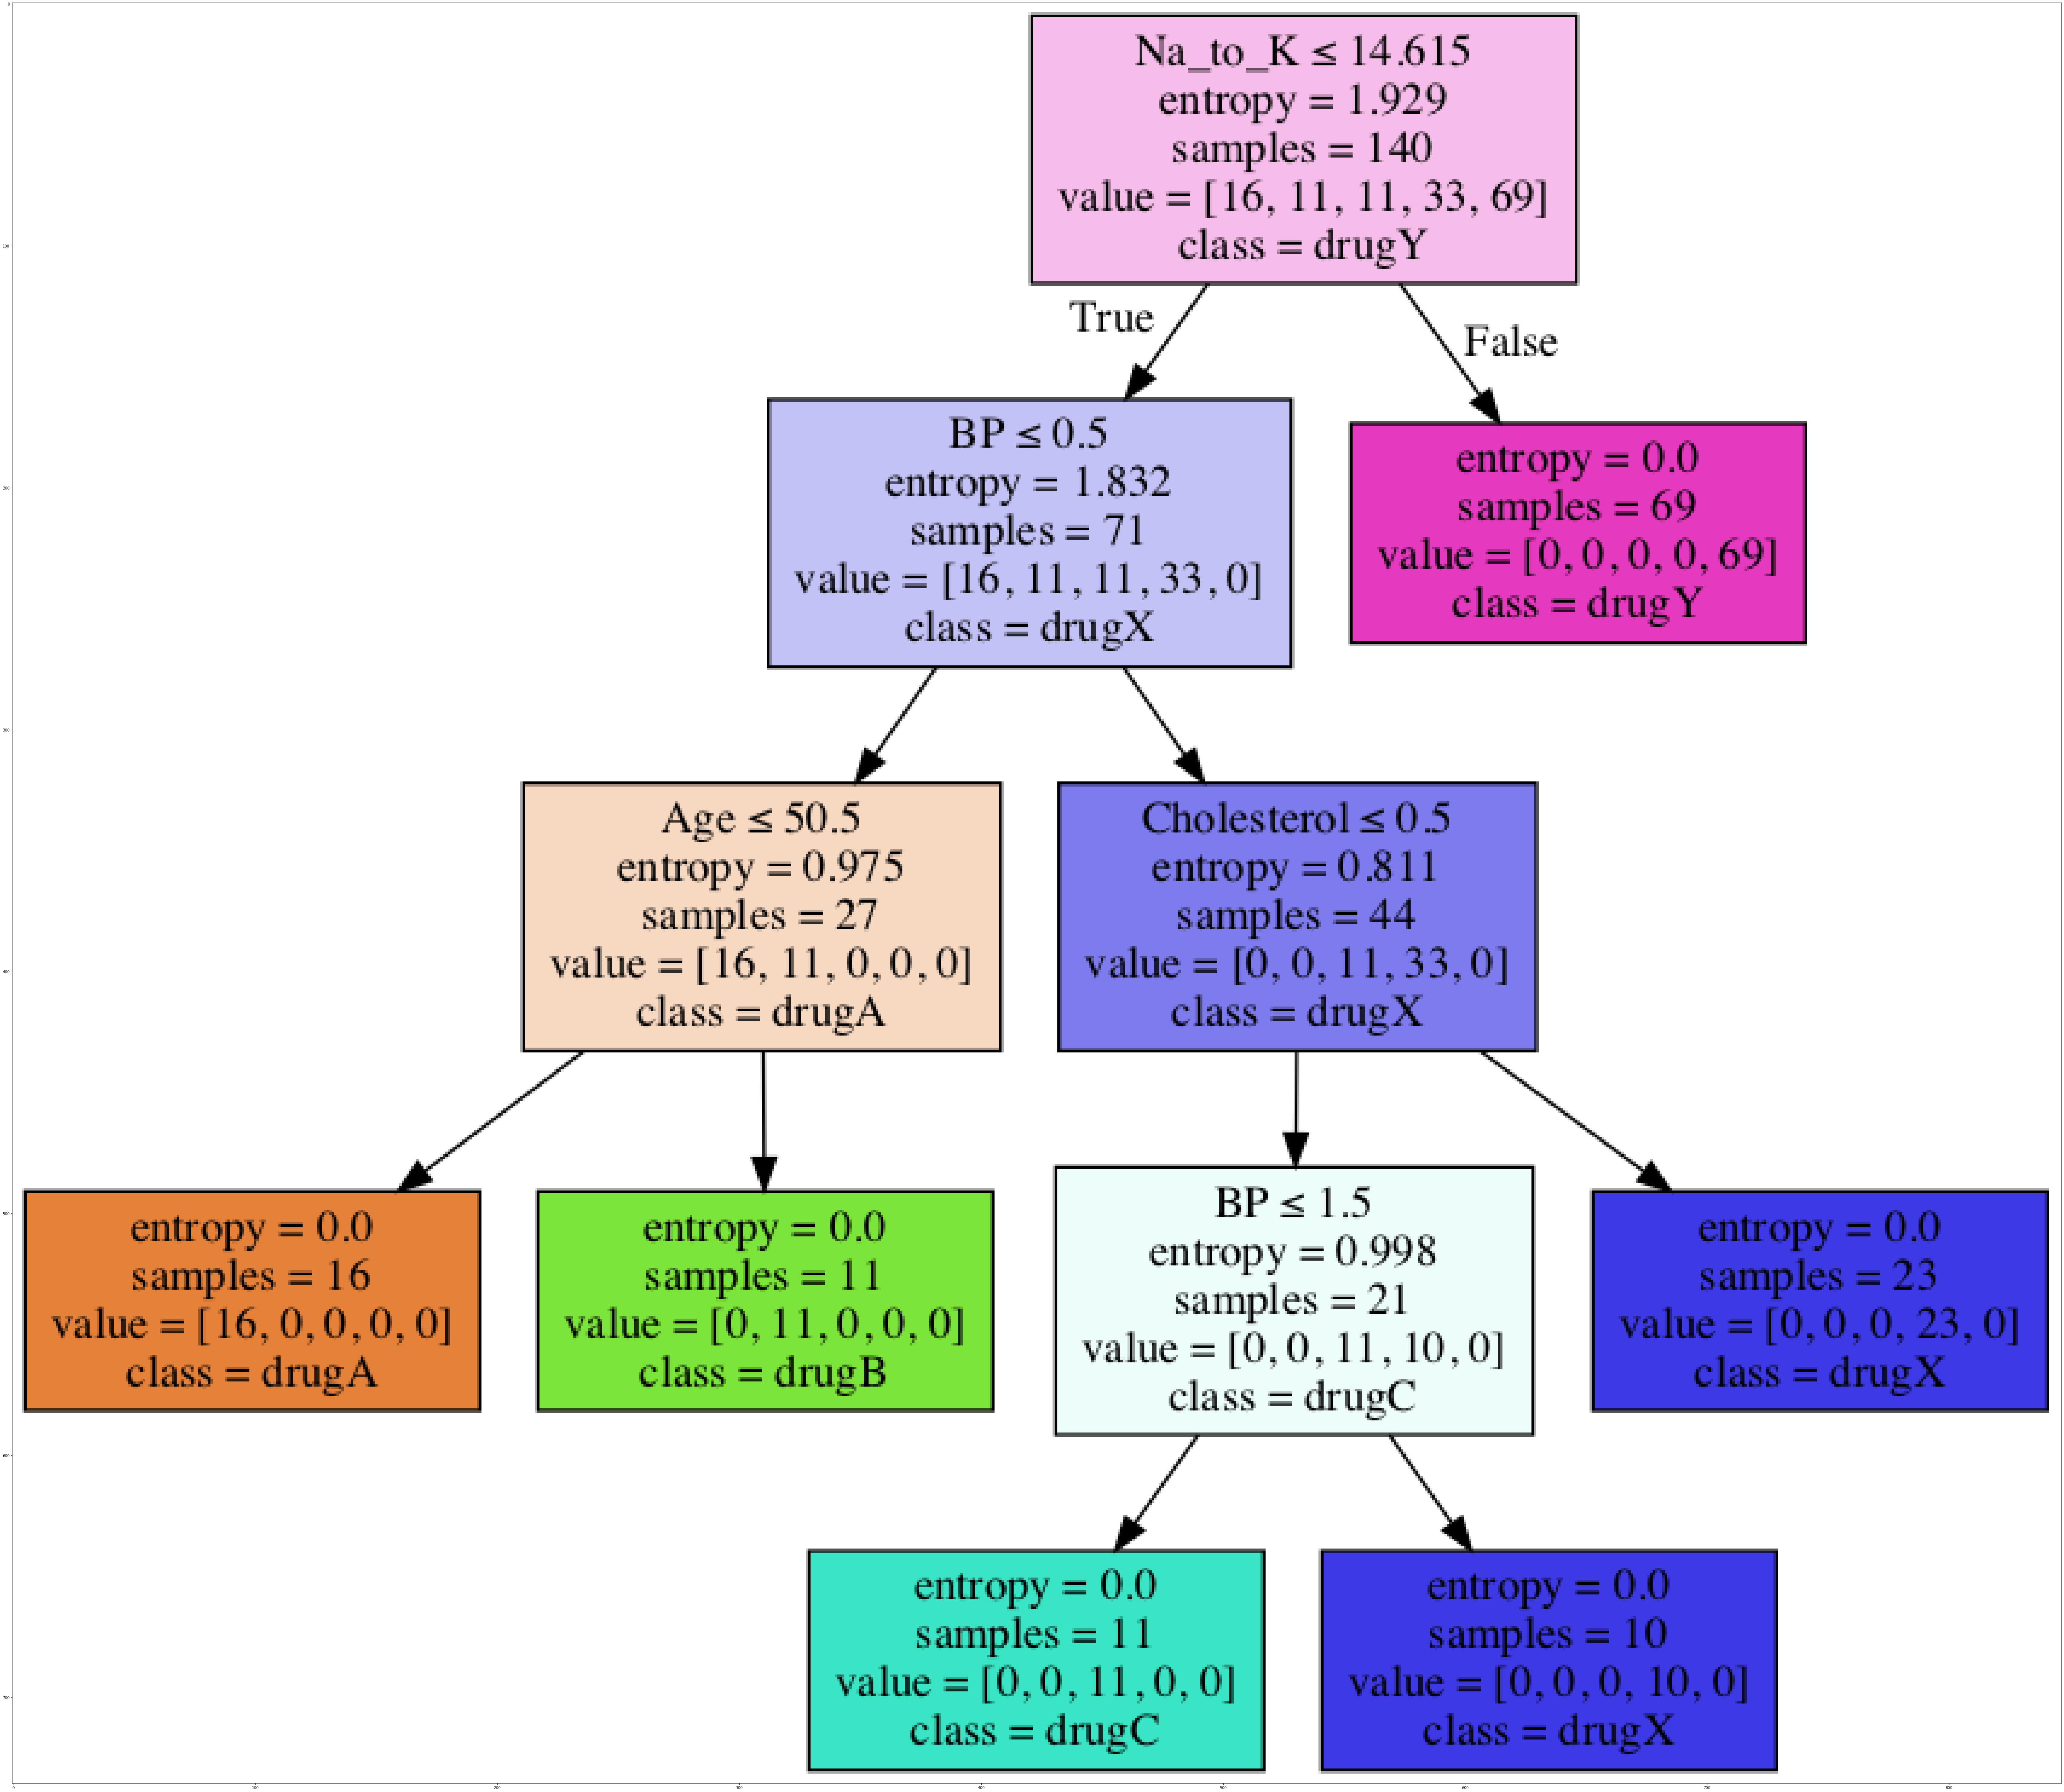

In [25]:
dot_data = StringIO()
filename = "drugtree.png"
featureNames = df.columns[0:5]
targetNames = df["Drug"].unique().tolist()
out = tree.export_graphviz(model, feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True, special_characters=True, rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')